# Bladder Cancer

## Data processing

In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

import shap
import lime
import json
from lime.lime_tabular import LimeTabularExplainer


# data load
df_BCa = pd.read_csv('BCa_raw.csv') # 암 원본 데이터 중 diagnosis 탭 data
df_BCa['Age'].fillna(df_BCa['Age'].mean(), inplace=True)


c:\Users\PC\anaconda3\envs\XAI_ML1\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\PC\anaconda3\envs\XAI_ML1\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

In [2]:
# 독립변수와 종속변수 정의

X_lr = df_BCa[['CK8','CK18','PD-1','PD-L1','Gender','Age']]

# diagnosis의 Y값 ('Decision')

Y = df_BCa['Decision']

# Column name의 list
col_name_lr = ['CK8','CK18','PD-1','PD-L1','Gender','Age']

# 독립변수(X) DataFrame 리스트
X_sets = [X_lr]

# 각 X 데이터셋의 이름
X_dataset_names = ['X_lr']

# 종속변수(y) Series 리스트
Y_sets = [Y]

# Col name 리스트
col_name_sets = [col_name_lr]

sets_name = ['lr']

num_sets = len(X_sets)
num_sets = len(X_sets)

In [3]:
from sklearn.preprocessing import MinMaxScaler

# 스케일링된 데이터셋을 저장할 새로운 리스트
X_norm_sets = []

for i in range(num_sets):
    # 'Gender' column이 있는지 확인
    if 'Gender' in X_sets[i].columns:
        # Gender column 분리
        gender_column = X_sets[i]['Gender']
        
        # Gender column 제거한 나머지 column들에 대해 스케일링 진행
        X_without_gender = X_sets[i].drop('Gender', axis=1)
        
        scaler = MinMaxScaler()
        X_normalized_values = scaler.fit_transform(X_without_gender)
        
        # 스케일링된 DataFrame 생성 
        X_normalized_df = pd.DataFrame(X_normalized_values, columns=X_without_gender.columns)
        
        # Gender column 다시 추가
        X_normalized_df['Gender'] = gender_column.values
        
    else:
        # 'Gender' 열이 없는 경우, 모든 열에 대해 스케일링 진행
        scaler = MinMaxScaler()
        X_normalized_values = scaler.fit_transform(X_sets[i])
        # 스케일링된 DataFrame 생성 
        X_normalized_df = pd.DataFrame(X_normalized_values, columns=X_sets[i].columns)

    X_norm_sets.append(X_normalized_df)

    print(f"Preprocessing completed for {X_dataset_names[i]}")


Preprocessing completed for X_lr


## Model.fit & predict

### 1) Logistic Regression

In [4]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# model.fit
lr= LogisticRegression()


# List에 4개의 lr model 담기
lr_classifiers = [lr]

- model.predict_proba

In [5]:
# 교차 검증(StratifiedKFold cross-validation) 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# results_proba_lr 딕셔너리 생성
results_lr = {}

# proba_result_lr
proba_lr = []

# Thresholds 설정 (0.1부터 0.7까지 0.05 간격으로 sweep)
thresholds = np.arange(0.1, 0.7, 0.05)

# ROC curve와 AUC 계산을 위한 빈 리스트 생성
roc_auc_list_lr = [[[0]*len(thresholds) for a in range(skf.get_n_splits())] for b in range(num_sets)]
fpr_list_lr = [[[0]*len(thresholds) for a in range(skf.get_n_splits())] for b in range(num_sets)]
tpr_list_lr = [[[0]*len(thresholds) for a in range(skf.get_n_splits())] for b in range(num_sets)]

best_threshold = 0.45


for i in range(num_sets):
    cm_total_lr = [0]*len(thresholds)
    acc_total_lr = [0]*len(thresholds)
    prec_total_lr = [0]*len(thresholds)
    rec_total_lr = [0]*len(thresholds)
    f1_total_lr = [0]*len(thresholds)
    auc_total_lr = [0]*len(thresholds)
    
    for num in range(len(thresholds)):
        cm_total_lr.append(np.zeros((2,2)))
        
    X_lr = X_sets[i].values
    Y_lr = Y_sets[i].values

    for j, (train_index, test_index) in enumerate(skf.split(X_lr, Y_lr)):
        X_train, X_test = X_lr[train_index], X_lr[test_index]
        Y_train, Y_test = Y_lr[train_index], Y_lr[test_index]

        lr_classifiers[i].fit(X_train, Y_train)
        predictions_proba=lr_classifiers[i].predict_proba(X_test)[:,1]
        fold_results = list(zip(test_index,predictions_proba))
        proba_lr.append(fold_results)
        predictions_xai = (predictions_proba > best_threshold).astype(int)
        
        # 예측과 실제값이 다른 index 추출
        misclassified_indices = np.where(predictions_xai != Y_test)[0]
        misclassified_indices_test = test_index[predictions_xai != Y_test]
        print('잘못 예측한 index 번호 list',misclassified_indices_test)
        
        for index, index_test in zip(misclassified_indices, misclassified_indices_test):
            if i==0:
                print(f"SHAP Force Plot for misclassified data point {index_test} in set {i+1}:")
                print('index #',index_test,'의 실제 정답은',Y_sets[0][index_test],'예측 결과는',predictions_proba[index])
                # SHAP force plot 그리기
                explainer_lr = shap.LinearExplainer(lr_classifiers[0], X_train)
                shap_values_lr = explainer_lr.shap_values(X_sets[0].values)
                shap.initjs()
                # plt.figure()
                # Save SHAP force plot as an image file
                shap.force_plot(explainer_lr.expected_value, shap_values_lr[index_test], X_sets[0].iloc[index_test], show=False,matplotlib=True).savefig(f"lr_shap_plots/SHAP Force Plot for misclassified data point {index_test}.png")
                plt.close()

                # LIME table 그리기
                lime_explainer_1_lr = LimeTabularExplainer(X_sets[0].to_numpy(), feature_names=X_sets[0].columns.tolist(), class_names=['Not Decision', 'Decision'], verbose=True)
                lime_exp_1_lr = lime_explainer_1_lr.explain_instance(X_sets[0].iloc[index_test], lr_classifiers[0].predict_proba)
                # lime_exp_1_lr.show_in_notebook()
                # Save LIME table as an image file
                lime_exp_1_lr.save_to_file(f"lr_lime_plots/LIME table for misclassified data point {index_test}.html")
        
        
            
        for idx, threshold in enumerate(thresholds):
            predictions=(predictions_proba>threshold).astype(int)   # 확률을 이진 레이블로 변환
            # roc_curve 함수로 FPR (False Positive Rate)과 TPR (True Positive Rate) 계산
            fpr, tpr, thre = roc_curve(Y_test.astype(int), predictions_proba)
            # AUC 계산
            roc_auc = roc_auc_score(Y_test.astype(int), predictions_proba)
            fpr_list_lr[i][j] = fpr
            tpr_list_lr[i][j] = tpr
            roc_auc_list_lr[i][j][idx] = roc_auc
            cm_total_lr[idx]+=confusion_matrix(Y_test.astype(int),predictions)
            acc_total_lr[idx]+=accuracy_score(Y_test.astype(int),predictions)
            prec_total_lr[idx]+=precision_score(Y_test.astype(int),predictions)
            rec_total_lr[idx]+=recall_score(Y_test.astype(int),predictions)
            f1_total_lr[idx]+=f1_score(Y_test.astype(int), predictions)
            auc_total_lr[idx]+=roc_auc_score(Y_test.astype(int), predictions_proba)


            if f"Model {i+1}" not in results_lr:
                results_lr[f"Model {i+1}"]={}
                
            results_lr[f"Model {i+1}"][threshold]={
                "Confusion Matrix": cm_total_lr[idx],
                "Accuracy": acc_total_lr[idx] / skf.get_n_splits(),
                "Precision": prec_total_lr[idx] / skf.get_n_splits(),
                "Recall": rec_total_lr[idx] / skf.get_n_splits(),
                
                "F1-Score": f1_total_lr[idx] / skf.get_n_splits(),
                "AUC": auc_total_lr[idx] / skf.get_n_splits()
            }
        
            

# Predict_proba값 index 순서대로 정렬 후 저장          
sorted_result_lr = [0]
df_proba_lr = [0]
proba_lr = np.concatenate(proba_lr)
sorted_result_lr = proba_lr[proba_lr[:, 0].argsort()]
df_proba_lr = pd.DataFrame(sorted_result_lr[:,1], columns=['Predictor value'])
    
# csv로 저장
df_proba_lr.to_csv('Predictor value lr.csv', index=False)

잘못 예측한 index 번호 list [46 62 66 71 80 82]
SHAP Force Plot for misclassified data point 46 in set 1:
index # 46 의 실제 정답은 1 예측 결과는 0.3851771128562062


Intercept 0.6744263165531641
Prediction_local [0.41091869]
Right: 0.3851771128562062
SHAP Force Plot for misclassified data point 62 in set 1:
index # 62 의 실제 정답은 0 예측 결과는 0.7539202760268047


Intercept 0.6219037098572489
Prediction_local [0.58646267]
Right: 0.7539202760268047
SHAP Force Plot for misclassified data point 66 in set 1:
index # 66 의 실제 정답은 0 예측 결과는 0.46091085246340385


Intercept 0.6569830276972275
Prediction_local [0.43025609]
Right: 0.46091085246340385
SHAP Force Plot for misclassified data point 71 in set 1:
index # 71 의 실제 정답은 0 예측 결과는 0.723704639020828


Intercept 0.6932686935151451
Prediction_local [0.63047035]
Right: 0.723704639020828
SHAP Force Plot for misclassified data point 80 in set 1:
index # 80 의 실제 정답은 0 예측 결과는 0.9292353329501488


Intercept 0.6394375443922014
Prediction_local [0.77874845]
Right: 0.9292353329501488
SHAP Force Plot for misclassified data point 82 in set 1:
index # 82 의 실제 정답은 0 예측 결과는 0.711062760558999


Intercept 0.5896472850043085
Prediction_local [0.63245803]
Right: 0.711062760558999
잘못 예측한 index 번호 list [24 34 44 69 72 73 78]
SHAP Force Plot for misclassified data point 24 in set 1:
index # 24 의 실제 정답은 1 예측 결과는 0.11978659385584194


Intercept 0.8552653646796926
Prediction_local [0.1351042]
Right: 0.11978659385584194
SHAP Force Plot for misclassified data point 34 in set 1:
index # 34 의 실제 정답은 1 예측 결과는 0.39216700584479586


Intercept 0.6680335753205788
Prediction_local [0.33857227]
Right: 0.39216700584479586
SHAP Force Plot for misclassified data point 44 in set 1:
index # 44 의 실제 정답은 1 예측 결과는 0.23153159131491582


Intercept 0.6889508503449592
Prediction_local [0.29667253]
Right: 0.23153159131491582
SHAP Force Plot for misclassified data point 69 in set 1:
index # 69 의 실제 정답은 0 예측 결과는 0.5007708781271798


Intercept 0.5913777767356558
Prediction_local [0.52435464]
Right: 0.5007708781271798
SHAP Force Plot for misclassified data point 72 in set 1:
index # 72 의 실제 정답은 0 예측 결과는 0.8427817558499425


Intercept 0.45976860661090985
Prediction_local [0.89806832]
Right: 0.8427817558499425
SHAP Force Plot for misclassified data point 73 in set 1:
index # 73 의 실제 정답은 0 예측 결과는 0.6105335586509458


Intercept 0.5677076084647754
Prediction_local [0.63450199]
Right: 0.6105335586509458
SHAP Force Plot for misclassified data point 78 in set 1:
index # 78 의 실제 정답은 0 예측 결과는 0.6017004557289162


Intercept 0.5411907842899885
Prediction_local [0.63870678]
Right: 0.6017004557289162
잘못 예측한 index 번호 list [ 8 40 56 64 75 76]
SHAP Force Plot for misclassified data point 8 in set 1:
index # 8 의 실제 정답은 1 예측 결과는 0.12556448998685965


Intercept 0.778528265654926
Prediction_local [0.25661779]
Right: 0.12556448998685965
SHAP Force Plot for misclassified data point 40 in set 1:
index # 40 의 실제 정답은 1 예측 결과는 0.3618563671392057


Intercept 0.5839779300026736
Prediction_local [0.58824922]
Right: 0.3618563671392057
SHAP Force Plot for misclassified data point 56 in set 1:
index # 56 의 실제 정답은 0 예측 결과는 0.48017188712190345


Intercept 0.7064234934074922
Prediction_local [0.44199587]
Right: 0.48017188712190345
SHAP Force Plot for misclassified data point 64 in set 1:
index # 64 의 실제 정답은 0 예측 결과는 0.4672911438612112


Intercept 0.6381088725047632
Prediction_local [0.42196021]
Right: 0.4672911438612112
SHAP Force Plot for misclassified data point 75 in set 1:
index # 75 의 실제 정답은 0 예측 결과는 0.46498715138579055


Intercept 0.7208711748618889
Prediction_local [0.3821782]
Right: 0.46498715138579055
SHAP Force Plot for misclassified data point 76 in set 1:
index # 76 의 실제 정답은 0 예측 결과는 0.5181268028127913


Intercept 0.6571908839679372
Prediction_local [0.57569923]
Right: 0.5181268028127913
잘못 예측한 index 번호 list [ 7 67]
SHAP Force Plot for misclassified data point 7 in set 1:
index # 7 의 실제 정답은 1 예측 결과는 0.33154070992376733


Intercept 0.647777911429532
Prediction_local [0.3718425]
Right: 0.33154070992376733
SHAP Force Plot for misclassified data point 67 in set 1:
index # 67 의 실제 정답은 0 예측 결과는 0.7418656102680934


Intercept 0.5075770862175036
Prediction_local [0.75690389]
Right: 0.7418656102680934
잘못 예측한 index 번호 list [48 51 65]
SHAP Force Plot for misclassified data point 48 in set 1:
index # 48 의 실제 정답은 1 예측 결과는 0.24454041605142146


Intercept 0.7512756608537676
Prediction_local [0.33400879]
Right: 0.24454041605142146
SHAP Force Plot for misclassified data point 51 in set 1:
index # 51 의 실제 정답은 1 예측 결과는 0.4142506631531745


Intercept 0.6606660372037346
Prediction_local [0.63418109]
Right: 0.4142506631531745
SHAP Force Plot for misclassified data point 65 in set 1:
index # 65 의 실제 정답은 0 예측 결과는 0.6146581381140288


Intercept 0.5379227110408367
Prediction_local [0.55529811]
Right: 0.6146581381140288


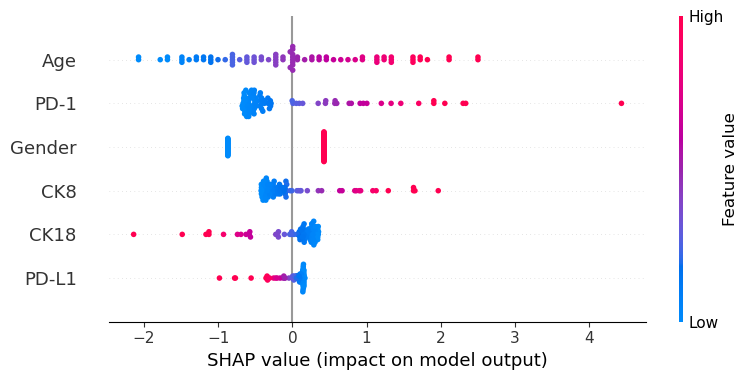

In [6]:
for i in range(num_sets):
    explainer_summary_lr = shap.LinearExplainer(lr_classifiers[0], X_train)
    shap_values_summary_lr = explainer_summary_lr.shap_values(X_sets[i].values)
    shap.summary_plot(shap_values_summary_lr, X_sets[i])

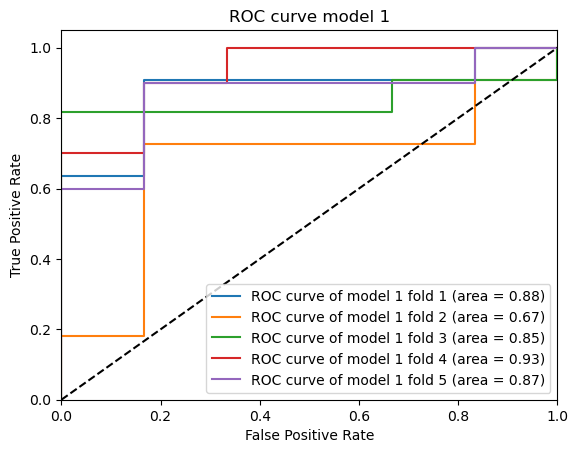

In [7]:
from sklearn.metrics import roc_curve, auc

i = 0  # 첫번째 모델 선택

# Fold 별로 반복
for j in range(skf.get_n_splits()):

    # 실제 레이블과 예측 확률을 기반으로 FPR, TPR 계산
    fpr = np.array(fpr_list_lr[i][j]).flatten()
    tpr = np.array(tpr_list_lr[i][j]).flatten()
    
    # AUC 계산
    roc_auc = auc(fpr, tpr)

    # ROC curve 그리기
    plt.plot(fpr, tpr, label=f'ROC curve of model {i+1} fold {j+1} (area = {roc_auc:0.2f})')
# 대각선 추가 (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve model 1')
plt.legend(loc="lower right")

# Plot 표시
plt.show()

In [8]:
# 데이터프레임 생성을 위한 빈 리스트 초기화
data_metrics_lr = []

# results_byth_lr 딕셔너리의 내용을 데이터프레임에 추가
for model, thresholds in results_lr.items():
    for threshold in thresholds:
        if threshold in thresholds:
            metrics = thresholds[threshold]
            accuracy = metrics['Accuracy']
            precision = metrics['Precision']
            recall = metrics['Recall']
            f1_score = metrics['F1-Score']
            auc = metrics['AUC']
        else:
            accuracy = None
            precision = None
            recall = None
            f1_score = None
            auc = None
            
        data_metrics_lr.append([model, threshold, accuracy, precision, recall, f1_score, auc])

# 데이터프레임 생성
df_metrics_lr = pd.DataFrame(data_metrics_lr, columns=['Model', 'Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-Score','AUC'])

df_metrics_lr

Model  Threshold  Accuracy  Precision    Recall  F1-Score       AUC
0   Model 1       0.10  0.638235   0.638235  1.000000  0.779121  0.838788
1   Model 1       0.15  0.627206   0.637745  0.963636  0.767285  0.838788
2   Model 1       0.20  0.652206   0.655602  0.963636  0.780106  0.838788
3   Model 1       0.25  0.651471   0.662500  0.925455  0.771778  0.838788
4   Model 1       0.30  0.713235   0.716071  0.925455  0.806264  0.838788
5   Model 1       0.35  0.725000   0.736201  0.905455  0.809820  0.838788
6   Model 1       0.40  0.713971   0.748765  0.850909  0.794405  0.838788
7   Model 1       0.45  0.713971   0.762906  0.830909  0.791398  0.838788
8   Model 1       0.50  0.748529   0.811190  0.810909  0.806115  0.838788
9   Model 1       0.55  0.747059   0.837518  0.770909  0.795052  0.838788
10  Model 1       0.60  0.747059   0.837518  0.770909  0.795052  0.838788
11  Model 1       0.65  0.771324   0.898413  0.752727  0.806842  0.838788

In [9]:
# 각 set 별 threshold 별 confusion matrix 출력
for i in range(num_sets):
    for idx, threshold in enumerate(thresholds):
        # Confusion Matrix 출력
        print(f"Set {sets_name[i]}, Threshold: {threshold}")
        print(results_lr[f"Model {i+1}"][threshold]["Confusion Matrix"])
        print()

# false negative들을 dictionary에 담기
false_negatives_lr = {}
for i in range(num_sets):
    for threshold in thresholds:
        if f"Model {i+1}" not in false_negatives_lr:
            false_negatives_lr[f"Model {i+1}"] = {}
        
        # False Negatives Rate 계산 및 저장
        cm = results_lr[f"Model {i+1}"][threshold]["Confusion Matrix"]
        false_negatives_rate = cm[1][0] / (cm[1][0] + cm[1][1])
        
        # False Negatives Rate를 dictionary에 저장
        false_negatives_rate_dict = {"False Negatives Rate": false_negatives_rate}
        false_negatives_lr[f"Model {i+1}"][threshold] = false_negatives_rate_dict

# 결과 확인하기
print(false_negatives_lr)


Set lr, Threshold: 0.1
[[ 0 30]
 [ 0 53]]

Set lr, Threshold: 0.15000000000000002
[[ 1 29]
 [ 2 51]]

Set lr, Threshold: 0.20000000000000004
[[ 3 27]
 [ 2 51]]

Set lr, Threshold: 0.25000000000000006
[[ 5 25]
 [ 4 49]]

Set lr, Threshold: 0.30000000000000004
[[10 20]
 [ 4 49]]

Set lr, Threshold: 0.3500000000000001
[[12 18]
 [ 5 48]]

Set lr, Threshold: 0.40000000000000013
[[14 16]
 [ 8 45]]

Set lr, Threshold: 0.45000000000000007
[[15 15]
 [ 9 44]]

Set lr, Threshold: 0.5000000000000001
[[19 11]
 [10 43]]

Set lr, Threshold: 0.5500000000000002
[[21  9]
 [12 41]]

Set lr, Threshold: 0.6000000000000002
[[21  9]
 [12 41]]

Set lr, Threshold: 0.6500000000000001
[[24  6]
 [13 40]]

{'Model 1': {0.1: {'False Negatives Rate': 0.0}, 0.15000000000000002: {'False Negatives Rate': 0.03773584905660377}, 0.20000000000000004: {'False Negatives Rate': 0.03773584905660377}, 0.25000000000000006: {'False Negatives Rate': 0.07547169811320754}, 0.30000000000000004: {'False Negatives Rate': 0.075471698113

In [10]:
# 데이터프레임 생성을 위한 빈 리스트 초기화
data_falsenegative_lr = []

# false_negatives_lr 딕셔너리의 내용을 데이터프레임에 추가
for model, thresholds in false_negatives_lr.items():
    for threshold, metrics in thresholds.items():
        false_neg_rate = metrics['False Negatives Rate']
        data_falsenegative_lr.append([model, threshold, false_neg_rate])

# 데이터프레임 생성
df_false_negatives_lr = pd.DataFrame(data_falsenegative_lr, columns=['Model', 'Threshold', 'False Negatives Rate'])

# 출력
df_false_negatives_lr

Model  Threshold  False Negatives Rate
0   Model 1       0.10              0.000000
1   Model 1       0.15              0.037736
2   Model 1       0.20              0.037736
3   Model 1       0.25              0.075472
4   Model 1       0.30              0.075472
5   Model 1       0.35              0.094340
6   Model 1       0.40              0.150943
7   Model 1       0.45              0.169811
8   Model 1       0.50              0.188679
9   Model 1       0.55              0.226415
10  Model 1       0.60              0.226415
11  Model 1       0.65              0.245283

In [11]:
# df_false_negatives와 df_byth_lr 합치기 (outer join)
df_combined_lr = pd.merge(df_false_negatives_lr, df_metrics_lr, on=["Model", "Threshold"],how="outer")

# 출력
df_combined_lr


Model  Threshold  False Negatives Rate  Accuracy  Precision    Recall  \
0   Model 1       0.10              0.000000  0.638235   0.638235  1.000000   
1   Model 1       0.15              0.037736  0.627206   0.637745  0.963636   
2   Model 1       0.20              0.037736  0.652206   0.655602  0.963636   
3   Model 1       0.25              0.075472  0.651471   0.662500  0.925455   
4   Model 1       0.30              0.075472  0.713235   0.716071  0.925455   
5   Model 1       0.35              0.094340  0.725000   0.736201  0.905455   
6   Model 1       0.40              0.150943  0.713971   0.748765  0.850909   
7   Model 1       0.45              0.169811  0.713971   0.762906  0.830909   
8   Model 1       0.50              0.188679  0.748529   0.811190  0.810909   
9   Model 1       0.55              0.226415  0.747059   0.837518  0.770909   
10  Model 1       0.60              0.226415  0.747059   0.837518  0.770909   
11  Model 1       0.65              0.245283  0.771324   0.898413  0.752727   

    F1-Score       AUC  
0   0.779121  0.838788  
1   0.767285  0.838788  
2   0.780106  0.838788  
3   0.771778  0.838788  
4   0.806264  0.838788  
5   0.809820  0.838788  
6   0.794405  0.838788  
7   0.791398  0.838788  
8   0.806115  0.838788  
9   0.795052  0.838788  
10  0.795052  0.838788  
11  0.806842  0.838788

In [12]:
# CSV 파일로 저장
df_combined_lr.to_csv('df_combined_lr.csv', index=False)
